In [1]:
import numpy as np
import matplotlib.pyplot as plt

First of all: we are going to introduce a dataset on that we apply our clustering method on:

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    epsilon = 0.1
    n = (np.random.rand(n_points,1)+epsilon) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise

    # hstack/vstack stacks data on top of each other (print shape to see what I mean)
    C_1 = np.hstack((d1x,d1y))
    C_2 = np.hstack((-d1x,-d1y))
    return np.vstack((C_1, C_2))

This is a dataset consisting of clusters twisting around each other. You don't need to understand the mathematics behind it, but you can play around with it if you like (make sure to train on the original dataset, not one you created)

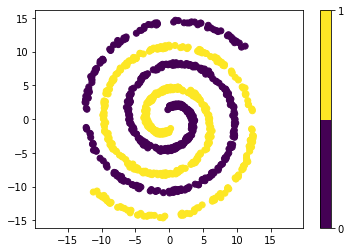

In [3]:
data_size = 500

dataset = twospirals(data_size)
labels = np.hstack((np.zeros(data_size),np.ones(data_size)))

# scatter makes a 2D scatter plot. Unfortunately you have to seperate the x-dim from the y-dim
# the labels are helpful for coloring. The algorithm does not use them, since this is unsupervised
plt.scatter(dataset[:,0], dataset[:,1], c = labels, cmap=plt.get_cmap('viridis',2))
plt.colorbar(ticks=np.arange(0,2))
plt.axis('equal')
plt.show()

In [7]:
import sys 
  
# the setrecursionlimit function is 
# used to modify the default recursion 
# limit set by python. Using this,  
# we can increase the recursion limit 
# to satisfy our needs 
  
#sys.setrecursionlimit(10**6) 


def euclidean_distance(x_1, x_2):
      return np.sqrt(np.sum((x_1-x_2)**2))#, axis = 1))



# Exercise 1. Implementation of a DBSCAN-Classiﬁer

a) Implement the DBSCAN algorithm to classify points of the two clusters.

b) Plot a scatter plot highlighting the clusters that were found after finding good hyperparameter values eps and minPts.

c) Print accuracies for different data_size values.

d) For what kind of data_size values does the algorithm fail and why? What would you say are disadvantages of DBSCAN?

## Part A: Implement the DBSCAN algorithm to classify points of the two clusters

In [8]:
dataset.shape

(1000, 2)

In [9]:
labels.shape

(1000,)

In [11]:
def createDistanceMatrix(dataset):
    n = len(dataset)
    matrix = np.array([[0.0]*n]*n)
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i][j] = euclidean_distance(dataset[i], dataset[j])
    return(matrix)

def rangeQuery(x, eps, matrix): # x is the point index
    x_dist_list = matrix[x]
    #EA: change to <= eps? PV: yeah, may be better, i also cleared the double usage of x
    N_indeces = [ind for ind, x_dist in enumerate(x_dist_list) if 0 < x_dist <= eps]
    return(N_indeces)

def DBSCAN(dataset, eps = 1, minPts = 4):
    labs = ['undefined'] * len(dataset)
    m = createDistanceMatrix(dataset)
    C = 0
    # EA: Select starting point randomly? PV: you could, but its not in the pseudo code
    for i in range(len(dataset)):
        if labs[i] != 'undefined':
            continue
        N = rangeQuery(i, eps, m)
        if len(N) < minPts:
            labs[i] = 'noise'
            continue
        # don't we need else here? PV: no, continue already interrupts if the 'if' is true
        C = C + 1
        labs[i] = str(C)
        if i in N:
            S = N[N != i]
        else:
            S = [x for x in N]
        for y in S:
            if labs[y] == 'noise':
                labs[y] = labs[i]
            # EA: change if -> elif for efficiency? PV: no, following the pseudo code, both if's have to be checked
            if labs[y] != 'undefined':
                continue
            else: # PV: this 'else' is not needed, because of the continue, could also write: if labs[y] == 'undefined': instead of if/else or if/continue
                labs[y] = labs[i]
                N = rangeQuery(y, eps, m)
                if len(N) >= minPts:
                    for k in range(len(N)):
                        S.append(N[k])
    return(labs)

## Part B: Plot a scatter plot highlighting the clusters that were found after finding good hyperparameter values eps and minPts

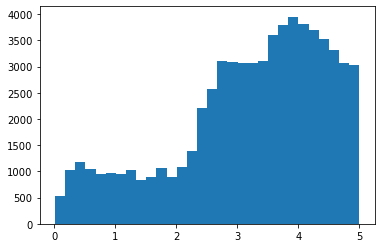

In [12]:
# EA: Find good parameter values for eps and minPts. For selecting a good eps I assumed, most of the points in 
# our hyperspherical space will have a larger pairwise distance and less points will have smaller pairwise distances.
# So in order to catch points of one cluster, the optimal eps value would lie in the area right before the 
# frequency of the following distances rapidly increases
# ==> Hyperparameter scaling using GridSearch too much?
M = createDistanceMatrix(dataset)
X = M[np.triu_indices(len(M[0]),1)]
plt.hist(X[X<5],bins=30)
plt.show()

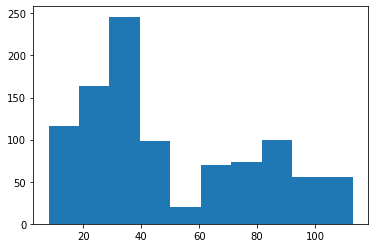

In [13]:
# Trying to determine the ideal setting for minPts based on eps did not wokr out as hoped
def get_epsilon_neighborhood(M, e):
    neighbors = []
    n = M.shape[0]
    for i in range(n):
        neighbors.append(len(np.where(M[:,i]<=e)[0])-1)
    return neighbors

N = get_epsilon_neighborhood(M,3)
plt.hist(N)
plt.show()

In [85]:
# best eps = 1.8
# best minPts => 2-4 (empirically determined)
labs = DBSCAN(dataset, eps = 1.6, minPts = 4)

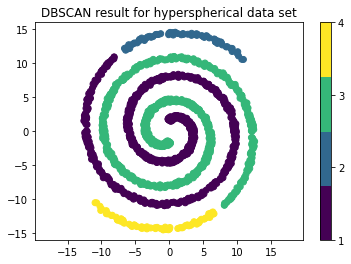

In [86]:
# EA: Does 'use matplotlib and numpy' mean that we are still allowed to use other libraries?
# Version only using plt and np
labs_int = [0 if x == 'noise' else int(x) for x in labs]
plt.scatter(dataset[:,0], dataset[:,1], c = labs_int, cmap=plt.get_cmap('viridis',len(set(labs))))
plt.colorbar(ticks=np.arange(0,len(set(labs)))+1)
plt.title('DBSCAN result for hyperspherical data set')
plt.axis('equal')
plt.show()

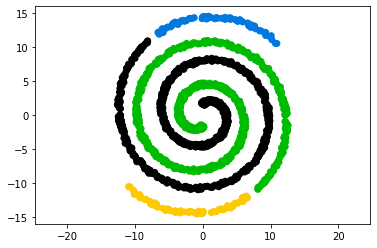

In [87]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib.cm import nipy_spectral

def get_n_colors(n):
    return[nipy_spectral(float(i)/n) for i in range(n) ]

labs_col, _ = pd.factorize(labs)
colors = get_n_colors(max(labs_col)+1)
cc = np.array(colors)[labs_col]
plt.scatter(dataset[:,0], dataset[:,1], c = cc)
plt.axis('equal')
plt.show()

In [11]:
"""
# how to find the index of a specific point in the dataset:
point = dataset[12]

index = np.where((dataset==point).all(axis=1))
print(dataset[index][0])
"""

'\n# how to find the index of a specific point in the dataset:\npoint = dataset[12]\n\nindex = np.where((dataset==point).all(axis=1))\nprint(dataset[index][0])\n'

## Part C:  Print accuracies for different data_size values

In [88]:
def Adjusted_Rand_Index(labels):
    """
    Compute ARI for data labelling
    """
    n = len(labels)
    ari = np.zeros((n,n))
    for i in range(n):
        x = labels[i]
        for j in range(n):
            ari[i,j] = int(x==labels[j])
    return np.triu(ari,1)

def Adjusted_Rand_Score(X,Y):
    """
    X : ari of ground truth labels
    Y : ari of clutering result
    """
    ars = X==Y
    ars = np.count_nonzero(ars.astype(int))/float(X.size)
    return ars

In [89]:
acc = []
for data_size in range(100,1000,100):
    dataset = twospirals(data_size)
    labels = np.hstack((np.zeros(data_size),np.ones(data_size)))
    labs = DBSCAN(dataset, eps=1.6, minPts=4)
    x = Adjusted_Rand_Index(labels)
    y = Adjusted_Rand_Index(labs)
    acc.append(Adjusted_Rand_Score(x,y))

In [90]:
len(acc)

9

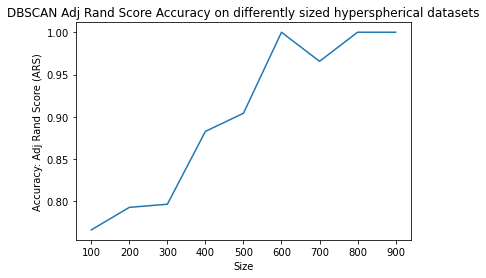

In [91]:
plt.figure()
plt.plot(range(100,1000,100), acc)
plt.title('DBSCAN Adj Rand Score Accuracy on differently sized hyperspherical datasets')
plt.xlabel('Size')
plt.ylabel('Accuracy: Adj Rand Score (ARS)')
plt.show()

In [94]:
for s, a in zip(range(100,1000,100), acc):
    print("Size:",s,"ARS:",a)

Size: 100 ARS: 0.766275
Size: 200 ARS: 0.7929375
Size: 300 ARS: 0.7966416666666667
Size: 400 ARS: 0.882784375
Size: 500 ARS: 0.904181
Size: 600 ARS: 1.0
Size: 700 ARS: 0.9656163265306122
Size: 800 ARS: 1.0
Size: 900 ARS: 1.0


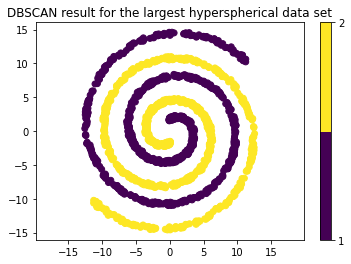

In [95]:
# plot the largest spiral dataset
labs_int = [0 if x == 'noise' else int(x) for x in labs]
plt.scatter(dataset[:,0], dataset[:,1], c = labs_int, cmap=plt.get_cmap('viridis',len(set(labs))))
plt.colorbar(ticks=np.arange(0,len(set(labs)))+1)
plt.title('DBSCAN result for the largest hyperspherical data set')
plt.axis('equal')
plt.show()

## Part D

### For what kind of data_size values does the algorithm fail and why?
The accuracy plot above shows an increasing clustering accuracy with increasing data size. The DBSCAN algorithm applied to the two_spirals data set converges to a 100% Rand Score accuracy. For the smaller datasets (size 100 - 500), the gaps in the spiral are larger than the gaps between spirals and it becomes hard to connect the outer parts of the spiral with lesser density. For everything with data size above 500, pretty much the whole spiral can be captured by the algorithm.

Assumption (for dataset of this assignment): 
- the bigger the data set, the denser the data distribution and the better the performance of a density-based approach

Explanation:
- The larger the data set, the "thicker" the spirals get and the closer the distance between points of individual spirals gets.
- For smaller data sets (which comprise scattered groups of differently dense data clouds), DBSCAN groups the data into significantly more clusters than ground truth comprises. Yet, this way, there still is a certain amount of data point pairs correctly clustered into the same or different clusters which keeps up the accuracy.

### What would you say are disadvantages of DBSCAN?
- DBSCAN performs inferior on data sets with different densities across the feature space
- In contrast to clustering method where we can predefine the number of clusters, DBSCAN might focus on a different partition of the data than we had in mind (depending on application: example from lecture would be the dog data set which could be clustered based on perspective of image or fur color; maybe the density-based most obvious grouping would be by color, while for our purpose it could be relevant to cluster by perspective of the photography)<br>
    => On the other hand, this cold maybe be accomplished by applying a weighted distance measure that redefines "density"